# Final Project - Coding

https://github.com/kmsravindra/ML-AI-experiments/blob/master/AI/knowledge_distillation/Knowledge%20distillation.ipynb

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure
import numpy as np
import seaborn as sns
from torch.autograd import Variable
import torchvision.utils as vutils
import os
import sys

# Load Data

In [2]:
# load data

batch_size = 100
train_set,test_set,train_loader,test_loader = {},{},{},{}

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])


# MNIST
train_set['mnist'] = dsets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_set['mnist'] = dsets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

# FMNIST
train_set['fmnist'] = dsets.FashionMNIST(root='./data', train=True, download=True)
train_loader['fmnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_set['fmnist'] = dsets.FashionMNIST(root='./data', train=False, download=True)
test_loader['fmnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

# CIFAR10
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), #pay attention to dimension here!!!
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_set['cifar10'] = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader['cifar10'] = torch.utils.data.DataLoader(train_set['cifar10'], batch_size=128, shuffle=True, num_workers=0)
test_set['cifar10'] = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader['cifar10'] = torch.utils.data.DataLoader(test_set['cifar10'], batch_size=128, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


# Part 1: Training Data is Available

## 1.1 Understanding Temperature - MNIST

In this section, we train a convolutional neural network to demonstrate how adding temperature can quantify the uncertainty of the prediction for each label. We extract the logits results before they are sent to the softmax activation function, divide them by temperatures, and then turn them into probabilities by softmax. We plot the probabilities under each temperature to show the choice of temperatures can reflect the extend of "correctness" of the model. We use MNIST as the similarity and difference between numbers are obvious to tell.

In [3]:
# define Teacher Network
class Teacher(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(Teacher, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.fc1 = nn.Linear(in_features = 64*12*12, out_features = 128)
        self.fc2 = nn.Linear(in_features = 128, out_features = 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x)) 
        #print(x.size())
        
        x = F.relu(self.conv2(x)) 
        #print(x.size())
        
        x = F.max_pool2d(x, kernel_size = 2) 
        #print(x.size())
        
        m1 = nn.Dropout(0.25)
        x = m1(x)
        #print(x.size())
        
        #flatten
        x = x.view(x.size(0), -1)
        #print(x.size())
        
        x = F.relu(self.fc1(x))
        m2 = nn.Dropout(0.5)
        x = m2(x)
        x = self.fc2(x) # will be using softmax; the final output before softmax
        
        return x

In [4]:
# define train & test for Teacher & Student w/o temperature
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
            epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    
    # want the output, which will be turned into probabilities
    # we also want to show the data and target for demonstration purpose
    return output, data, target

# define test
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, 100. * correct / len(test_loader.dataset)))
    
    return output, data, target

In [5]:
# train and test Teacher
seed = 1
device = 'cuda'
data_name = 'mnist'
num_epochs = 10
lr = 0.05
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
in_channels = 1 
out_channels = 10

In [6]:
model = Teacher(data_name, in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)

for epoch in range(1, num_epochs+ 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    pre_prob, test_data, test_target = test(model, device, test_loader[data_name], criterion, epoch)
    #print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 2.3196
Train(1)[50%]: Loss: 0.5612
Test(1): Loss: 0.1484, Accuracy: 95.6100%
Train(2)[0%]: Loss: 0.1560
Train(2)[50%]: Loss: 0.1447
Test(2): Loss: 0.1010, Accuracy: 97.0700%
Train(3)[0%]: Loss: 0.1402
Train(3)[50%]: Loss: 0.1031
Test(3): Loss: 0.0837, Accuracy: 97.4900%
Train(4)[0%]: Loss: 0.0704
Train(4)[50%]: Loss: 0.0824
Test(4): Loss: 0.0791, Accuracy: 97.7300%
Train(5)[0%]: Loss: 0.0996
Train(5)[50%]: Loss: 0.0687
Test(5): Loss: 0.0698, Accuracy: 97.8500%
Train(6)[0%]: Loss: 0.0795
Train(6)[50%]: Loss: 0.0613
Test(6): Loss: 0.0717, Accuracy: 97.8700%
Train(7)[0%]: Loss: 0.0378
Train(7)[50%]: Loss: 0.0518
Test(7): Loss: 0.0675, Accuracy: 97.8900%
Train(8)[0%]: Loss: 0.0267
Train(8)[50%]: Loss: 0.0497
Test(8): Loss: 0.0574, Accuracy: 98.2300%
Train(9)[0%]: Loss: 0.0117
Train(9)[50%]: Loss: 0.0410
Test(9): Loss: 0.0577, Accuracy: 98.2900%
Train(10)[0%]: Loss: 0.0219
Train(10)[50%]: Loss: 0.0413
Test(10): Loss: 0.0528, Accuracy: 98.3100%


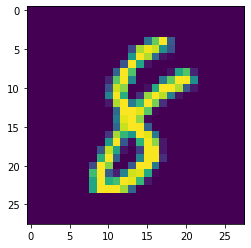

In [7]:
# demonstration of the effect of temperature
# plot the result of from the last episode
# use the first image in the test data
plt.imshow(test_data[0][0].cpu())
plt.show()

In [8]:
# define softmax function
def soft_max(x):
    return np.exp(x)/(np.exp(x).sum())

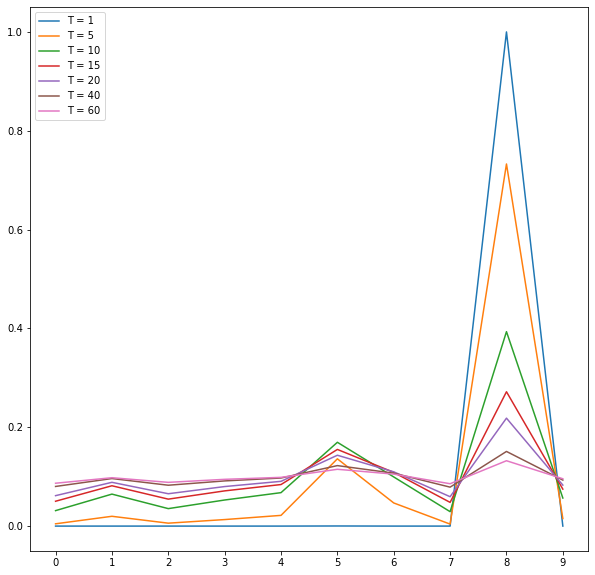

In [9]:
# plot the predicted probabilities for each label for the first image
# with different temperature
image_8_raw = pre_prob[0].cpu()
T = [1, 5, 10, 15, 20, 40, 60]
plt.figure(figsize=(10,10)) 
plt.xticks(np.arange(10))
for t in T:
    prob_with_temp = soft_max(image_8_raw/t)
    plt.plot(prob_with_temp, label = 'T = ' + str(t))
plt.legend()
plt.show()

## 1.2 Compare and Contrast: exmperiment on FashionMNIST
In this section, we continue with our Teacher Network and build a Student Network. We'll compare how the test accuracies differ by the prediction results from the Teacher Network, the Student Network, and the Student Network with temperature.

In [10]:
# define Student Network
class Student(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(Student, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        m = nn.Dropout(0.2)
        x = m(x)
        x = self.fc2(x) # will use softmax
    
        return x

In [11]:
# train and test Teacher with FMNIST
seed = 1
data_name = 'fmnist'
in_channels = 1
out_channels = 10
model = Teacher(data_name, in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)

In [12]:
for epoch in range(1, num_epochs+ 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    #print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 2.3420
Train(1)[50%]: Loss: 0.5603
Test(1): Loss: 0.1521, Accuracy: 95.3700%
Train(2)[0%]: Loss: 0.2208
Train(2)[50%]: Loss: 0.1406
Test(2): Loss: 0.0992, Accuracy: 97.0300%
Train(3)[0%]: Loss: 0.0816
Train(3)[50%]: Loss: 0.0986
Test(3): Loss: 0.0771, Accuracy: 97.6000%
Train(4)[0%]: Loss: 0.0881
Train(4)[50%]: Loss: 0.0784
Test(4): Loss: 0.0722, Accuracy: 97.8100%
Train(5)[0%]: Loss: 0.0294
Train(5)[50%]: Loss: 0.0703
Test(5): Loss: 0.0614, Accuracy: 98.0900%
Train(6)[0%]: Loss: 0.0819
Train(6)[50%]: Loss: 0.0571
Test(6): Loss: 0.0620, Accuracy: 98.2500%
Train(7)[0%]: Loss: 0.0199
Train(7)[50%]: Loss: 0.0519
Test(7): Loss: 0.0547, Accuracy: 98.3000%
Train(8)[0%]: Loss: 0.0249
Train(8)[50%]: Loss: 0.0486
Test(8): Loss: 0.0601, Accuracy: 98.2300%
Train(9)[0%]: Loss: 0.0239
Train(9)[50%]: Loss: 0.0406
Test(9): Loss: 0.0530, Accuracy: 98.3600%
Train(10)[0%]: Loss: 0.0564
Train(10)[50%]: Loss: 0.0371
Test(10): Loss: 0.0553, Accuracy: 98.1500%


In [13]:
# train and test Student with FMNIST
model = Student(data_name, in_channels, out_channels).to(device)
optimizer = optim.SGD(model.parameters(), lr = lr)

for epoch in range(1, num_epochs+ 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)
    #print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

Train(1)[0%]: Loss: 2.3649
Train(1)[50%]: Loss: 0.6763
Test(1): Loss: 0.3197, Accuracy: 90.6800%
Train(2)[0%]: Loss: 0.3024
Train(2)[50%]: Loss: 0.3278
Test(2): Loss: 0.2698, Accuracy: 91.9900%
Train(3)[0%]: Loss: 0.3621
Train(3)[50%]: Loss: 0.2730
Test(3): Loss: 0.2414, Accuracy: 92.7900%
Train(4)[0%]: Loss: 0.2201
Train(4)[50%]: Loss: 0.2470
Test(4): Loss: 0.2268, Accuracy: 93.0700%
Train(5)[0%]: Loss: 0.2592
Train(5)[50%]: Loss: 0.2296
Test(5): Loss: 0.2353, Accuracy: 93.0400%
Train(6)[0%]: Loss: 0.3282
Train(6)[50%]: Loss: 0.2179
Test(6): Loss: 0.2129, Accuracy: 93.8000%
Train(7)[0%]: Loss: 0.0858
Train(7)[50%]: Loss: 0.2052
Test(7): Loss: 0.2078, Accuracy: 93.9600%
Train(8)[0%]: Loss: 0.2244
Train(8)[50%]: Loss: 0.1956
Test(8): Loss: 0.2034, Accuracy: 93.9000%
Train(9)[0%]: Loss: 0.1946
Train(9)[50%]: Loss: 0.1882
Test(9): Loss: 0.1998, Accuracy: 93.9500%
Train(10)[0%]: Loss: 0.4582
Train(10)[50%]: Loss: 0.1813
Test(10): Loss: 0.1952, Accuracy: 94.1100%


In [14]:
# define the loss function of the Student Network with temperature
# negative log loss
def loss_distill(out, target):
    return -torch.mean(target * torch.log(out))

In [15]:
def one_hot_encoder(y):
    place_holder = torch.zeros((len(y), 10))
    one_hot = place_holder.scatter(1, y.unsqueeze(1), 1)
    return one_hot

In [16]:
# define train and test for Student Network with temperature
def train_w_t(t_model, s_model, temperature, device, train_loader, lr):
    t_optimizer = optim.SGD(t_model.parameters(), lr = lr)
    s_optimizer = optim.SGD(s_model.parameters(), lr = lr)
    
    t_train_loss = 0
    s_train_loss = 0
    t_model.train()
    s_model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = one_hot_encoder(target) # one-hot encoding
        target = target.to(device)
        
        t_optimizer.zero_grad()
        s_optimizer.zero_grad()
        
        # extract the logits in teacher model and softened it by temperature
        t_logits = t_model(data)
        t_logits_soft = t_logits/temperature
        
        # get probabilities from teacher model
        t_pred = torch.softmax(t_logits, dim = 1)
        t_pred_soft = torch.softmax(t_logits_soft, dim = 1) # this will be part of the prediction that student model will make; 
                                              # by predicting the softened probabilities prediction from teacher, the dark knowledge is transfered
        
        # extract the logits in student model
        s_logits = s_model(data)
        s_logits_soft = s_logits/temperature
        
        # get probabilities from student model
        s_pred = torch.softmax(s_logits, dim = 1)
        s_pred_soft = torch.softmax(s_logits, dim = 1)
        
        # loss
        t_loss = loss_distill(t_pred_soft, target)
        s_loss_soft = loss_distill(s_pred_soft, target)
        s_loss_target = loss_distill(s_pred_soft, t_pred)
        
        s_loss = s_loss_soft + s_loss_target # weighted loss
        
        # update
        t_loss.backward(retain_graph = True)
        s_loss.backward(retain_graph = True)
        
        t_optimizer.step()
        s_optimizer.step()
        
        t_train_loss += t_loss.item()
        s_train_loss += s_loss.item()
        
        if batch_idx % (len(train_loader)//2) == 0:
            print('Teacher: Train({})[{:.0f}%]: Loss: {:.4f}'.format(
            epoch, 100. * batch_idx / len(train_loader), t_train_loss/(batch_idx+1)))
            print('Student: Train({})[{:.0f}%]: Loss: {:.4f}'.format(
            epoch, 100. * batch_idx / len(train_loader), s_train_loss/(batch_idx+1)))

In [17]:
# define train and test for Student Network with temperature
def test_w_t(t_model, s_model, device, test_loader):
    t_model.eval()
    s_model.eval()
    
    t_corrects = 0
    s_corrects = 0
    
    t_test_loss = 0
    s_test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = one_hot_encoder(target) # one-hot encoding
            target = target.to(device)
        
            # extract the logits in teacher model and softened it by temperature
            t_logits = t_model(data)
        
            # get probabilities from teacher model
            t_pred = torch.softmax(t_logits, dim = 1)
        
            # extract the logits in student model
            s_logits = s_model(data)
        
            # get probabilities from student model
            s_pred = torch.softmax(s_logits, dim = 1)
        
            # loss
            t_loss = loss_distill(t_pred, target)
            s_loss_soft = loss_distill(s_pred, target)
            s_loss_target = loss_distill(s_pred, t_pred)
        
            s_loss = s_loss_soft + s_loss_target # weighted loss
        
            # calculating acc
            #??????
            t_corrects += (torch.max(t_pred, 1)[1].data == torch.max(target, 1)[1].data).sum()
            s_corrects += (torch.max(s_pred, 1)[1].data == torch.max(target, 1)[1].data).sum()
        
            # calculating loss
            t_test_loss += t_loss.item()
            s_test_loss += s_loss.item()
        
    t_test_loss = (t_test_loss*batch_size)/len(test_loader.dataset)
    s_test_loss = (s_test_loss*batch_size)/len(test_loader.dataset)
    
    print('Teacher: Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, t_test_loss, 100. * t_corrects / len(test_loader.dataset)))
    print('Student: Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, s_test_loss, 100. * s_corrects / len(test_loader.dataset)))

In [18]:
# train Student with FMNIST
teacher_model = Teacher(data_name, in_channels, out_channels).to(device)
student_model = Student(data_name, in_channels, out_channels).to(device)

for epoch in range(1, num_epochs+ 1):
    train_w_t(teacher_model, 
              student_model,
              10, 
              device, 
              train_loader[data_name],
              0.05)
    test_w_t(teacher_model, 
              student_model,
              device, 
              test_loader[data_name])

Teacher: Train(1)[0%]: Loss: 0.2303
Student: Train(1)[0%]: Loss: 0.4673
Teacher: Train(1)[50%]: Loss: 0.2318
Student: Train(1)[50%]: Loss: 0.3065
Teacher: Test(1): Loss: 0.6670, Accuracy: 12.5600%
Student: Test(1): Loss: 0.2056, Accuracy: 33.2000%
Teacher: Train(2)[0%]: Loss: 0.2126
Student: Train(2)[0%]: Loss: 0.2057
Teacher: Train(2)[50%]: Loss: 0.1732
Student: Train(2)[50%]: Loss: 0.1878
Teacher: Test(2): Loss: nan, Accuracy: 82.0300%
Student: Test(2): Loss: 0.1086, Accuracy: 83.2700%
Teacher: Train(3)[0%]: Loss: 0.0680
Student: Train(3)[0%]: Loss: 0.1101
Teacher: Train(3)[50%]: Loss: 0.0590
Student: Train(3)[50%]: Loss: 0.1040
Teacher: Test(3): Loss: nan, Accuracy: 86.1500%
Student: Test(3): Loss: 0.0840, Accuracy: 86.6100%
Teacher: Train(4)[0%]: Loss: 0.0532
Student: Train(4)[0%]: Loss: 0.0982
Teacher: Train(4)[50%]: Loss: 0.0471
Student: Train(4)[50%]: Loss: 0.0843
Teacher: Test(4): Loss: nan, Accuracy: 87.5700%
Student: Test(4): Loss: 0.0752, Accuracy: 87.7000%
Teacher: Train(5)

## 1.3 Compare and Contrast: exmperiment on CIFAR10

In [19]:
# define teacher
class LeNet5(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding = 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding = 0)
        self.fc1 = nn.Linear(in_features=16*6*6, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        
        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.relu(x)
        
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.relu(x)
        
        # Reshape the feature maps to vector
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # will be using softmax, so no activation func for the 3rd one; pre
        
        return x

In [20]:
# define student
class LeNet5_Half(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(LeNet5_Half, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=5, stride=1, padding = 2)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding = 0)
        self.fc1 = nn.Linear(in_features=8*6*6, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        
        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.relu(x)
        
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.relu(x)
        
        # Reshape the feature maps to vector
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # will be using softmax, so no activation func for the 3rd one; pre
        
        return x

In [21]:
# train and test Teacher with FMNIST
seed = 1
data_name = 'cifar10'
in_channels = 3
out_channels = 10
num_epochs = 30

In [22]:
# train Student with FMNIST
teacher_model = LeNet5(data_name, in_channels, out_channels).to(device)
student_model = LeNet5_Half(data_name, in_channels, out_channels).to(device)

for epoch in range(1, num_epochs+ 1):
    train_w_t(teacher_model, 
              student_model,
              3, 
              device, 
              train_loader[data_name],
              0.05)
    test_w_t(teacher_model, 
              student_model,
              device, 
              test_loader[data_name])

Teacher: Train(1)[0%]: Loss: 0.2300
Student: Train(1)[0%]: Loss: 0.4609
Teacher: Train(1)[50%]: Loss: 0.2303
Student: Train(1)[50%]: Loss: 0.4605
Teacher: Train(1)[100%]: Loss: 0.2303
Student: Train(1)[100%]: Loss: 0.4602
Teacher: Test(1): Loss: 0.1820, Accuracy: 10.5300%
Student: Test(1): Loss: 0.3631, Accuracy: 15.8400%
Teacher: Train(2)[0%]: Loss: 0.2306
Student: Train(2)[0%]: Loss: 0.4599
Teacher: Train(2)[50%]: Loss: 0.2303
Student: Train(2)[50%]: Loss: 0.4593
Teacher: Train(2)[100%]: Loss: 0.2302
Student: Train(2)[100%]: Loss: 0.4588
Teacher: Test(2): Loss: 0.1819, Accuracy: 11.0700%
Student: Test(2): Loss: 0.3612, Accuracy: 18.0000%
Teacher: Train(3)[0%]: Loss: 0.2301
Student: Train(3)[0%]: Loss: 0.4579
Teacher: Train(3)[50%]: Loss: 0.2302
Student: Train(3)[50%]: Loss: 0.4563
Teacher: Train(3)[100%]: Loss: 0.2302
Student: Train(3)[100%]: Loss: 0.4546
Teacher: Test(3): Loss: 0.1819, Accuracy: 10.1100%
Student: Test(3): Loss: 0.3556, Accuracy: 23.3500%
Teacher: Train(4)[0%]: Loss:

# Part 2: Training Data is Not Available

## 2.1 Generate Data Impression from Train

https://github.com/da2so/Zero-shot_Knowledge_Distillation_Pytorch/blob/master/ZSKD.py  \
The following code snippets are modified from the above  link

In [23]:
# Calculate the similarity matrix
def get_class_similarity(teacher_model):

    # Find last layer
    t_layer = list(teacher_model.children())[-1]
    
    # Get the weights from the last layer
    t_weights = list(t_layer.parameters())[0].cuda()  # size(#class number, #weights in final-layer )

    # Compute similarity matrix
    t_weights_norm = F.normalize(t_weights, p=2, dim=1)
    cls_sim = torch.matmul(t_weights_norm, t_weights_norm.T)
    
    #??????
    cls_sim_norm = torch.div(cls_sim - torch.min(cls_sim, dim=1).values,
                            torch.max(cls_sim, dim=1).values - torch.min(cls_sim, dim=1).values)
    return cls_sim_norm  

In [31]:
# generate synthesized data 
def ZSKD(num_class, teacher_model, num_crafted, scaling_factors, temperature,
        batch_size, num_channels, width, height,
        n_iters, data_set):
    """
    Input: Teacher model (trained), number of DIs crafted per category, scaling factors beta, temperature
    Output: Data Impressions
    """
    
    file_num=np.zeros((num_class),dtype=int)
    loss = nn.BCELoss()
    cls_sim_mat = get_class_similarity(teacher_model)
    for k in range(num_class):
        for b in scaling_factors:
            for n in range(num_crafted // len(scaling_factors)):
                
                #sample y_n^k ~ Dir(K, beta_b * alpha^k)
                dir_dist = torch.distributions.dirichlet.Dirichlet(b * cls_sim_mat[k])
                y = Variable(dir_dist.rsample((batch_size,)), requires_grad = False)
                
                #initialize x_bar_k_n to random noise and craft impression
                x_bar = torch.randn(batch_size, num_channels, width, height).cuda()
                x_bar = Variable(x_bar, requires_grad = True)
                
                #optimization to craft the image
                optimizer = torch.optim.Adam([x_bar], 0.05)
                
                for n_iter in range(n_iters): #to find the minimum
                    optimizer.zero_grad()
                    soft_logit = teacher_model(x_bar)/temperature
                    out = nn.Softmax(dim = 1)(soft_logit)
                    
                    l = loss(out, y.detach())
                    l.backward()
                    optimizer.step()
                    
                # save the synthesized images
                t_cls = torch.argmax(y, dim=1).detach().cpu().numpy() #synthesized target
                save_root = './di_img/'+data_set+'/'
                for m in range(batch_size):
                    save_dir = save_root+str(t_cls[m])+'/'
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)
                    else:
                        vutils.save_image(x_bar[m, :, :, :].data.clone(), save_dir + str(file_num[t_cls[m]]) + '.jpg', normalize=True)

                    file_num[t_cls[m]]+=1

    return save_root


## 2.2 Experiment on FashionMNIST

In [25]:
# define teacher
class LeNet5(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(LeNet5, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding = 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding = 0)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        
        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.relu(x)
        
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.relu(x)
        
        # Reshape the feature maps to vector
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # will be using softmax, so no activation func for the 3rd one; pre
        
        return x

In [26]:
# define student
class LeNet5_Half(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(LeNet5_Half, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=3, kernel_size=5, stride=1, padding = 2)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding = 0)
        self.fc1 = nn.Linear(in_features=8*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        
        x = F.max_pool2d(self.conv1(x), kernel_size=2)
        x = F.relu(x)
        
        x = F.max_pool2d(self.conv2(x), kernel_size=2)
        x = F.relu(x)
        
        # Reshape the feature maps to vector
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # will be using softmax, so no activation func for the 3rd one; pre
        
        return x

In [27]:
### Train Teacher
seed = 1
data_name = 'fmnist'
in_channels = 1
out_channels = 10
num_epochs = 10
model = LeNet5(data_name, in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr)

In [28]:
for epoch in range(1, num_epochs+ 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)

Train(1)[0%]: Loss: 2.3147
Train(1)[50%]: Loss: 0.9175
Test(1): Loss: 0.1015, Accuracy: 96.8600%
Train(2)[0%]: Loss: 0.0574
Train(2)[50%]: Loss: 0.1056
Test(2): Loss: 0.0617, Accuracy: 97.9700%
Train(3)[0%]: Loss: 0.0438
Train(3)[50%]: Loss: 0.0724
Test(3): Loss: 0.0502, Accuracy: 98.3400%
Train(4)[0%]: Loss: 0.1049
Train(4)[50%]: Loss: 0.0527
Test(4): Loss: 0.0440, Accuracy: 98.4500%
Train(5)[0%]: Loss: 0.0836
Train(5)[50%]: Loss: 0.0454
Test(5): Loss: 0.0400, Accuracy: 98.5900%
Train(6)[0%]: Loss: 0.0219
Train(6)[50%]: Loss: 0.0392
Test(6): Loss: 0.0383, Accuracy: 98.7000%
Train(7)[0%]: Loss: 0.0355
Train(7)[50%]: Loss: 0.0300
Test(7): Loss: 0.0354, Accuracy: 98.8900%
Train(8)[0%]: Loss: 0.0049
Train(8)[50%]: Loss: 0.0297
Test(8): Loss: 0.0334, Accuracy: 98.9100%
Train(9)[0%]: Loss: 0.0062
Train(9)[50%]: Loss: 0.0251
Test(9): Loss: 0.0330, Accuracy: 98.9900%
Train(10)[0%]: Loss: 0.0159
Train(10)[50%]: Loss: 0.0211
Test(10): Loss: 0.0356, Accuracy: 98.9000%


In [29]:
cl_sim_mat_fmnist = get_class_similarity(model)

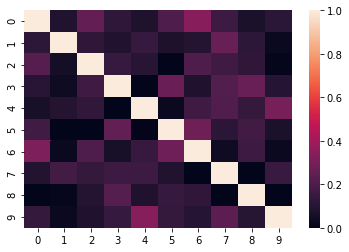

In [30]:
sns.heatmap(cl_sim_mat_fmnist.cpu().detach().numpy())
pass

In [32]:
ZSKD(num_class = 10, teacher_model = model, num_crafted = 10, scaling_factors = [0.1,1,0.1,1,1,0.1,0.1,1,1,0.1], 
     temperature = 20,
        batch_size = 100, num_channels = 1, width = 28, height = 28,
        n_iters = 100, data_set = data_name)

'./di_img/fmnist/'

## 2.3 Experiment on CIFAR10

In [9]:
# define Teacher
class AlexNet(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(AlexNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=48, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 48, out_channels = 128, kernel_size = 5, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 192, kernel_size = 3, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size = 3, stride = 1)
        self.fc1 = nn.Linear(in_features=128*3*3, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=10)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        lrn = nn.LocalResponseNorm(2) # the rest values are defaults
        x = lrn(x)
        x = F.max_pool2d(x, kernel_size=3)
        
        x = F.relu(self.conv2(x))
        x = lrn(x)
        x = F.max_pool2d(x, kernel_size=1)
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.conv4(x))
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=1)
        
        x = x.view(x.size(0), -1)
        
        bn = nn.BatchNorm2d(1)
        x = F.relu(self.fc1(x))
        dout = nn.Dropout(0.5)
        x = dout(x)
        
        x = F.relu(self.fc2(x))
        x = dout(x)
        
        x = self.fc3(x)

In [10]:
# define Student
class AlexNet_Half(nn.Module):
    def __init__(self, data_name, in_channels, out_channels):
        super(AlexNet_Half, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=24, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 24, out_channels = 64, kernel_size = 5, stride = 1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 96, kernel_size = 3, stride = 1)
        self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 96, kernel_size = 3, stride = 1)
        self.conv5 = nn.Conv2d(in_channels = 96, out_channels = 64, kernel_size = 3, stride = 1)
        self.fc1 = nn.Linear(in_features=64*3*3, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        lrn = nn.LocalResponseNorm(2) # the rest values are defaults
        x = lrn(x)
        x = F.max_pool2d(x, kernel_size=3)
        
        x = F.relu(self.conv2(x))
        x = lrn(x)
        x = F.max_pool2d(x, kernel_size=1)
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.conv4(x))
        
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=1)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        dout = nn.Dropout(0.5)
        x = dout(x)
        
        x = F.relu(self.fc2(x))
        x = dout(x)
        
        x = self.fc3(x)

In [11]:
### Train Teacher
seed = 1
data_name = 'cifar10'
in_channels = 3
out_channels = 10
model = AlexNet(data_name, in_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
for epoch in range(1, num_epochs+ 1):
    train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test(model, device, test_loader[data_name], criterion, epoch)